In [44]:
# 📦 Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans


In [45]:
# 📥 Step 1: Load Data (Las Vegas)
df = pd.read_csv("Resources/lasvegaslistings.csv")


In [46]:
# 🧹 Step 2: Data Cleaning
selected_columns = [
    "price", "latitude", "longitude", "room_type", "minimum_nights",
    "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "neighbourhood"
]
df_model = df[selected_columns].dropna()
df_model = df_model[df_model["price"] > 0]

# 💵 Cap outliers in price
price_cap = df_model["price"].quantile(0.95)
df_model = df_model[df_model["price"] <= price_cap]


In [47]:
# 🧠 Step 3: Feature Engineering
df_model["location_cluster"] = KMeans(n_clusters=5, random_state=42, n_init=10).fit_predict(df_model[["latitude", "longitude"]])
df_model["log_reviews"] = np.log1p(df_model["number_of_reviews"])
df_model["log_reviews_per_month"] = np.log1p(df_model["reviews_per_month"])
df_model["minnights_x_reviews"] = df_model["minimum_nights"] * df_model["reviews_per_month"]
df_model["lat_squared"] = df_model["latitude"] ** 2
df_model["long_squared"] = df_model["longitude"] ** 2

In [48]:
# 🎯 Create Binary Target
df_model["price_class"] = pd.qcut(df_model["price"], q=2, labels=[0, 1])

In [49]:
# 🏗️ Step 4: Define Features and Pipeline
X = df_model[[
    "latitude", "longitude", "lat_squared", "long_squared", "log_reviews", "log_reviews_per_month",
    "minimum_nights", "minnights_x_reviews", "calculated_host_listings_count", "availability_365",
    "room_type", "location_cluster", "neighbourhood"
]]
y = df_model["price_class"].astype(int)

numeric_features = [
    "latitude", "longitude", "lat_squared", "long_squared",
    "log_reviews", "log_reviews_per_month", "minimum_nights",
    "minnights_x_reviews", "calculated_host_listings_count", "availability_365"
]
categorical_features = ["room_type", "location_cluster", "neighbourhood"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_features),
    ]
)

In [50]:
# 🤖 Step 5: Hyperparameter Tuning
results = []
param_grid = [
    {"n_estimators": 300, "max_depth": None},
    {"n_estimators": 400, "max_depth": 30},
    {"n_estimators": 500, "max_depth": 40},
    {"n_estimators": 600, "max_depth": 50},
]

for params in param_grid:
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            random_state=42,
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"]
        ))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"n_estimators": params["n_estimators"], "max_depth": params["max_depth"], "accuracy": acc})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="accuracy", ascending=False)
print(results_df)


   n_estimators  max_depth  accuracy
0           300        NaN  0.809935
2           500       40.0  0.809935
3           600       50.0  0.808855
1           400       30.0  0.808315


In [51]:
# 🏆 Step 6: Train Best Model
best_result = results_df.iloc[0]
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        n_estimators=int(best_result["n_estimators"]),
        max_depth=None if pd.isna(best_result["max_depth"]) else int(best_result["max_depth"])
    ))
])
best_model.fit(X_train, y_train)
y_pred_rf = best_model.predict(X_test)

In [52]:
# 💾 Save model and predictions
predictions = pd.DataFrame({
    "Actual": y_test,
    "RF_Predicted": y_pred_rf
})
predictions.to_csv("las_vegas_price_model_comparison.csv", index=False)
joblib.dump(best_model, "airbnb_rf_model.pkl")

['airbnb_rf_model.pkl']

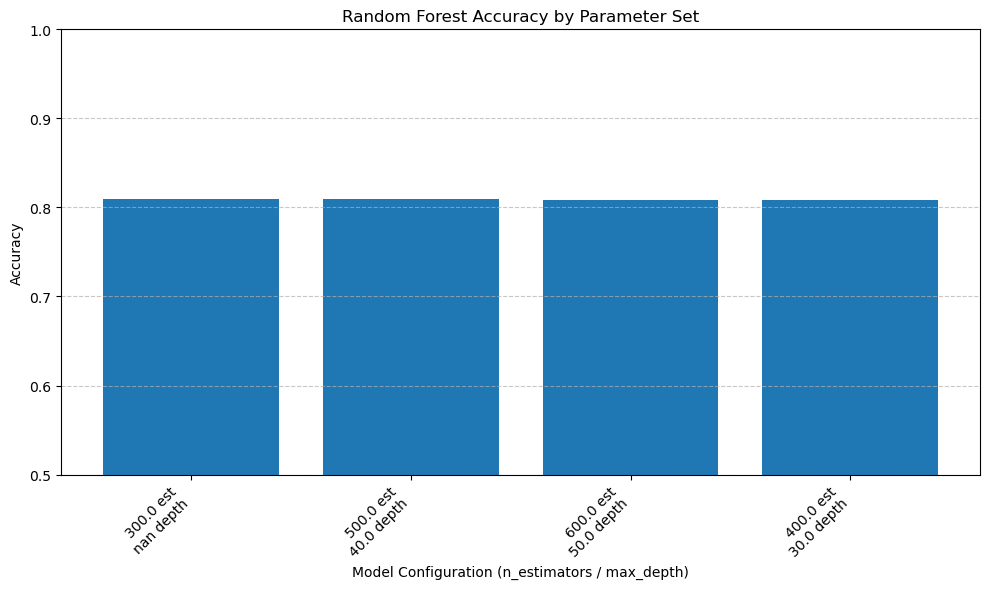

In [53]:
# 📊 Visualize Accuracy
plt.figure(figsize=(10, 6))
plt.bar(
    [f"{row['n_estimators']} est\n{row['max_depth']} depth" for _, row in results_df.iterrows()],
    results_df["accuracy"]
)
plt.title("Random Forest Accuracy by Parameter Set")
plt.xlabel("Model Configuration (n_estimators / max_depth)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

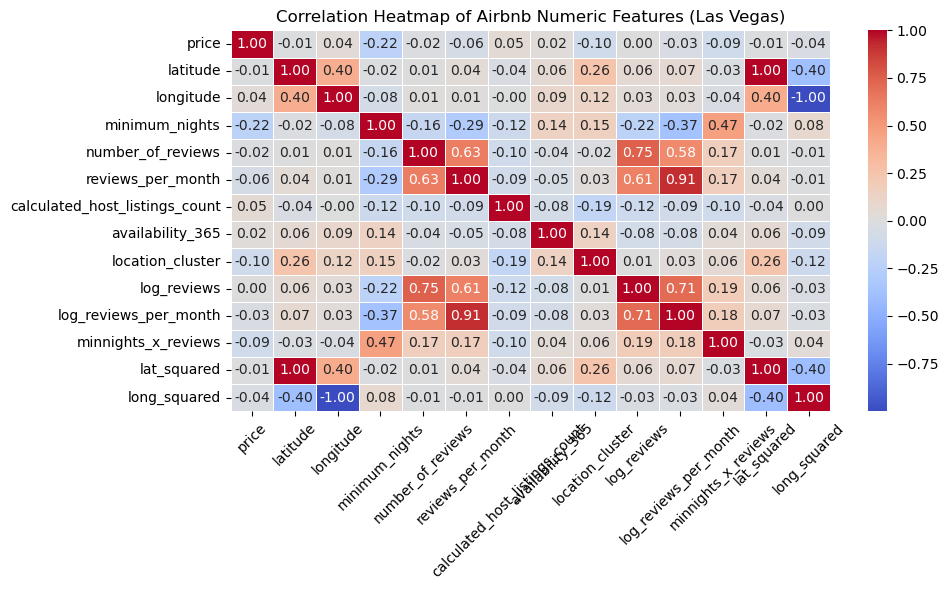

In [54]:
# 🧪 Correlation Heatmap (Fix: numeric columns only)
plt.figure(figsize=(10, 6))
numeric_df = df_model.select_dtypes(include=[np.number])  # only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Airbnb Numeric Features (Las Vegas)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
# 📈 Price Distribution Histogram
fig = px.histogram(df_model, x="price", nbins=50, title="Price Distribution in Las Vegas")
fig.write_json("price_dist.json")

In [56]:
# 📊 Feature Importance
feature_importances = pd.Series(
    best_model.named_steps["classifier"].feature_importances_
)
fig = px.bar(
    x=feature_importances.index,
    y=feature_importances.values,
    title="Feature Importances"
)
fig.write_json("feature_importance.json")


In [57]:
# # 🗺️ GeoJSON for Leaflet Map
gdf = gpd.GeoDataFrame(df_model, geometry=gpd.points_from_xy(df_model.longitude, df_model.latitude))
gdf = gdf[["geometry", "price"]]
gdf.set_crs(epsg=4326, inplace=True)  # Set CRS to WGS84
gdf.to_file("listings.geojson", driver="GeoJSON")